In [1]:
import sys
import os
import numpy as np
import pandas as pd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import networkx as nx
import copy

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import matrix_operation
import diffusionNMF
import grid_search
import nmf
from matrix_operation import mat_opr
from diffusionNMF import diffusionNMF
from grid_search import gridSearcher
from nmf import nmf

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1

# US State Level Data

### Cleaning + Load data

In [3]:
# Case counts
state_dset = pd.read_csv(os.path.join(par, 'collected_data/state_dataset.csv'), index_col = 0)
state_dset = mat_opr(state_dset)

In [4]:
# population data
population = pd.read_csv(os.path.join(par, 'collected_data/state_census_estimate.csv'), index_col = 'NAME')

In [5]:
# adjacency Laplacian
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()

In [6]:
# clean + normalize
state_iso = state_dset.iso()
pop_dict = {}
for col in state_iso.dataframe.columns:
    pop_dict[col] = population.loc[col,'POP']
    
state_norm = state_iso.population_normalizer(pop_dict)

In [7]:
# json file with geographic info for each state -- required for graphing
state_map = os.path.join(par, 'collected_data/US_States_geojson.json')

### Results

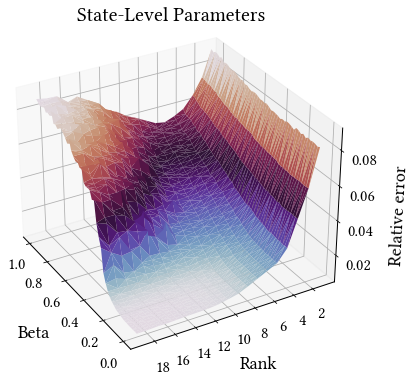

In [9]:
state_grid2 = pd.read_csv("./testing_data/covid_state_grid_search.csv", index_col = 0)
#state_grid2 = state_grid2[state_grid2["rank"] <= 10]
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(state_grid2['beta'], state_grid2['rank'], state_grid2['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

ax.xaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
#ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("State-Level Parameters", fontsize = 20)
ax.view_init(30,150)
ax.dist = 9

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_grid.pdf')

In [20]:
twod = state_grid2[state_grid2["beta"] == 1]

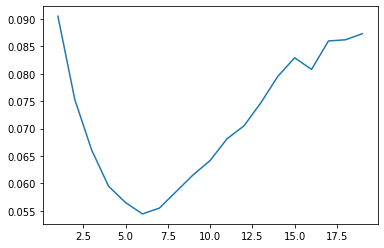

In [25]:
plt.plot(twod["rank"], twod["relative error"])

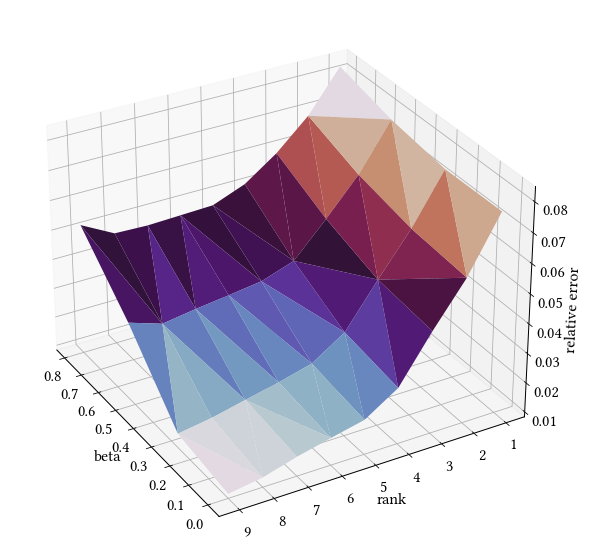

In [5]:
#state_grid3 = pd.read_csv("./testing_data/covid_state_grid_search_hidden2.csv")
#state_grid3 = state_grid3[state_grid3["beta"] < 1]

state_grid3 = pd.read_csv("./testing_data/state_grid_search_adj.csv")
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(state_grid3['beta'], state_grid3['rank'], state_grid3['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

In [44]:
rank = 6
beta = 0.2
K = np.linalg.inv(np.identity(len(state_L)) + beta * state_L)
dNMF = diffusionNMF(n_components = rank, kernel = K, n_iter = 100000, tol = 1e-9)
X,V = dNMF.fit_transform(state_norm.dataframe)

Max iterations reached, increase to converge on given tolerance


In [45]:
X = pd.DataFrame(X, index = state_norm.dataframe.index)
V = pd.DataFrame(V, columns = state_norm.dataframe.columns)

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


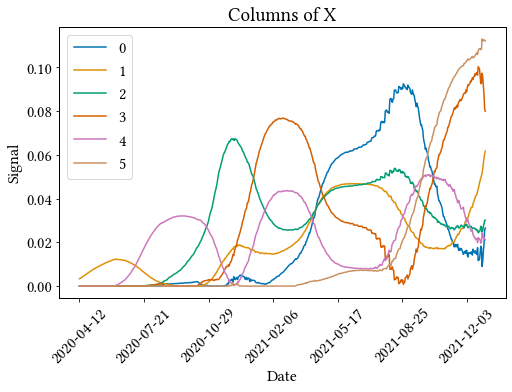

In [53]:
X.plot(figsize = (8,5))
plt.xticks(rotation = 45)
plt.xlabel("Date")
plt.ylabel("Signal")
plt.title("Columns of X")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_X.pdf')
plt.show()

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)
for r in [V.index[0]]:
    basis = V.loc[r,:] 
    
    folium.Choropleth(
    geo_data=state_map,
    data=basis,
    key_on="feature.properties.NAME",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

#folium.LayerControl('topleft', collapsed = False).add_to(m)
m
#m.save('state_map.html')

In [65]:
from selenium import webdriver
import time
driver = webdriver.Chrome()
driver.set_window_size(1000, 3000)  # choose a resolution
driver.get('file:///C:/Users/kq146/code/covid_college_tracker/Covid_data/analysis/state_map.html')
# You may need to add time.sleep(seconds) here
time.sleep(5)
driver.save_screenshot('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_map1.png')

True

In [ ]:
VK = V @ K
VK.columns = state_norm.dataframe.columns

m = folium.Map(location=[48, -102], zoom_start=3)
for r in [VK.index[0]]:
    basis = VK.loc[r,:] 
    
    folium.Choropleth(
    geo_data=state_map,
    data=basis,
    key_on="feature.properties.NAME",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

folium.LayerControl().add_to(m)
m

In [29]:
nmfer = nmf(rank, n_iter = 100000, tol = 1e-8)
W,H = nmfer.fit_transform(state_norm.dataframe)

In [30]:
W = pd.DataFrame(W, index = state_norm.dataframe.index)
H = pd.DataFrame(H, columns = state_norm.dataframe.columns)

<AxesSubplot:>

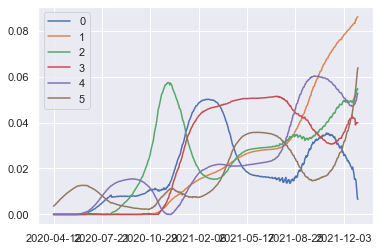

In [31]:
W.plot()

# US County Level Data

In [57]:
def rescale(X,V,K = None):
    X = copy.deepcopy(X)
    V = copy.deepcopy(V)

    maxer = np.amax(X)
    X /= maxer
    V *= maxer
    
    return X,V

In [3]:
# geo json map
county_map = os.path.join(par, 'collected_data/US_counties_geo.json')

# county laplacian
countyLaplacian = pd.read_csv(os.path.join(par, "collected_data/countyLaplacian.csv"), index_col = 0)
countyLaplacian.columns = countyLaplacian.columns.astype("int")

# county census data for normalization
county_pop = pd.read_csv(os.path.join(par, "collected_data/county_census.csv"), index_col = "fips")

### New England

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


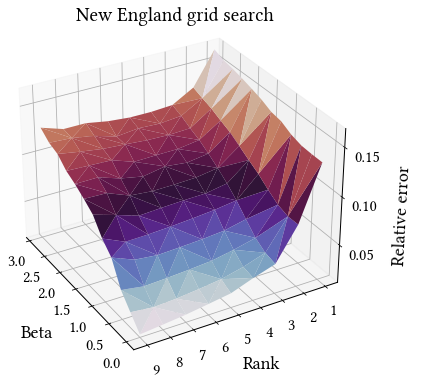

In [132]:
new_eng_grid = pd.read_csv("./testing_data/new_eng_grid.csv")
new_eng_grid = new_eng_grid.loc[new_eng_grid["beta"] <= 3]
fig = plt.figure(figsize = (14,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(new_eng_grid['beta'], new_eng_grid['rank'], new_eng_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)

ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("New England grid search")
ax.view_init(30,150)
ax.dist = 9

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/grid_newEng.pdf')

In [5]:
new_eng = pd.read_csv(os.path.join(par, 'collected_data/county_dataset.csv'), index_col = [0,1,2])
new_eng = new_eng.loc[new_eng.index.get_level_values("state").isin(["New York", "Connecticut", "Maine", "Vermont",
                                                       "Massachusetts", "New Hampshire", "Rhode Island"])]
new_eng.index = new_eng.index.get_level_values("fips")
new_eng = new_eng.T

In [6]:
ne_lapl = countyLaplacian.loc[new_eng.columns,new_eng.columns].to_numpy()
ne_pop = county_pop.loc[new_eng.columns, :]

In [319]:
'''
import json

with open(os.path.join(par, "collected_data/US_counties_geo.json"), 'r') as f:
    data = json.load(f)
    new_eng_counties = {'type': "FeatureCollection", "features":[]}
    for feat in range(len(data['features'])):
        county_id = data['features'][feat]['properties']['COUNTY_ID']
        
        if int(county_id) in new_eng.columns:
            new_eng_counties['features'].append(data['features'][feat])
        
    new_f = open(os.path.join(par, "collected_data/new_eng_counties_geo.json"), "w")
    json.dump(new_eng_counties, new_f)
    f.close()
    new_f.close()
'''

ne_map = os.path.join(par, 'collected_data/new_eng_counties_geo.json')

In [7]:
# clean + normalize
new_eng_dset = mat_opr(new_eng)
new_eng_iso = new_eng_dset.iso()
pop_dict = {}
for col in new_eng_iso.dataframe.columns:
    pop_dict[col] = ne_pop.loc[col,'Population Estimate']        
    
new_eng_norm = new_eng_iso.population_normalizer(pop_dict)

In [8]:
errs = []
for r in range(1,15):
    nmfer = nmf(r, n_iter = 50000, tol = 1e-9)
    W,H = nmfer.fit_transform(new_eng_norm.dataframe)
    err = np.linalg.norm(new_eng_norm.dataframe - np.dot(W,H))/np.linalg.norm(new_eng_norm.dataframe)
    errs.append(err)

Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance


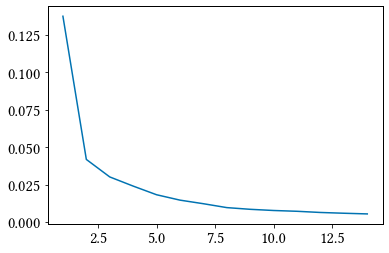

In [187]:
plt.plot(range(1,15), errs)

In [145]:
rank = 3
beta = 1
K = np.linalg.inv(np.identity(len(ne_lapl)) + beta * ne_lapl)
dNMF = diffusionNMF(n_components = rank, kernel = K, n_iter = 500000  , tol = 1e-10)
X,V = dNMF.fit_transform(new_eng_norm.dataframe)

In [147]:
X,V = rescale(X,V,K)
X = pd.DataFrame(X, index = new_eng_norm.dataframe.index)
V = pd.DataFrame(V, columns = new_eng_norm.dataframe.columns)

In [323]:
nmfer = nmf(3, n_iter = 500000, tol = 1e-10)
W,H = nmfer.fit_transform(new_eng_norm.dataframe)

In [324]:
W,H = rescale(W,H)
W = pd.DataFrame(W, index = new_eng_norm.dataframe.index)
H = pd.DataFrame(H, columns = new_eng_norm.dataframe.columns)

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


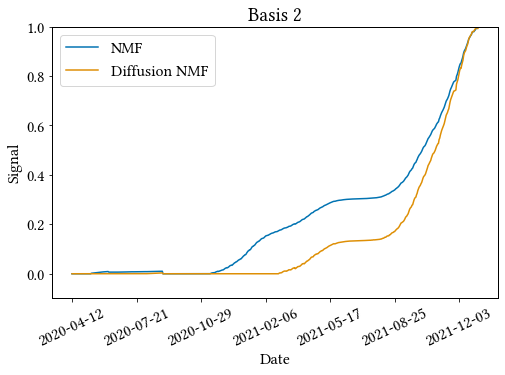

In [230]:
W[0].plot(label = "NMF", figsize = (8,5))
X[1].plot(label = "Diffusion NMF")
plt.ylim(-0.1,1)
plt.xticks(rotation = 25)
plt.xlabel("Date")
plt.ylabel("Signal")
plt.title("Basis 2")
plt.legend()
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_basis2.pdf', bbox_inches = "tight")

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


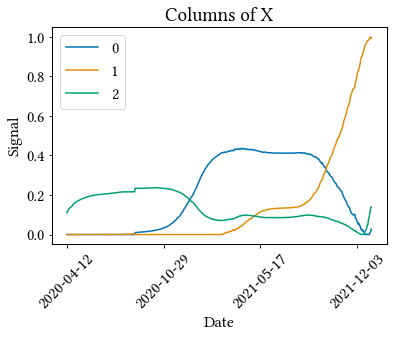

In [150]:
X.plot()
plt.xticks(rotation = 45)
plt.xlabel("Date")
plt.ylabel("Signal")
plt.title("Columns of X")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_X.pdf')
plt.show()

In [320]:
m = folium.Map(location=[43, -73],width = 800, height = 800, zoom_start=6)
for r in [V.index[1]]:
    basis = V.loc[r,:]
    
    folium.Choropleth(
    geo_data=ne_map ,
    data=basis,
    key_on="feature.properties.COUNTY_ID",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

m
#m.save('new_eng.html')

In [322]:
VK = V @ K
VK.columns = new_eng_norm.dataframe.columns

m = folium.Map(location=[43, -73],width = 800, height = 800, zoom_start=6)
for r in [VK.index[1]]:
    basis = VK.loc[r,:] 
    
    folium.Choropleth(
    geo_data=ne_map,
    data=basis,
    key_on="feature.properties.COUNTY_ID",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

#folium.LayerControl().add_to(m)
m
#m.save('new_eng.html')

In [338]:
m = folium.Map(location=[43, -73],width = 800, height = 800, zoom_start=6)
for r in [H.index[0]]:
    basis = H.loc[r,:] 
    
    folium.Choropleth(
    geo_data=ne_map,
    data=basis,
    key_on="feature.properties.COUNTY_ID",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

#folium.LayerControl().add_to(m)
m
#m.save('new_eng.html')

In [219]:
from selenium import webdriver
import time
driver = webdriver.Chrome()
driver.set_window_size(1000, 3000)  # choose a resolution
driver.get('file:///C:/Users/kq146/code/covid_college_tracker/Covid_data/analysis/new_eng.html')
# You may need to add time.sleep(seconds) here
time.sleep(2)
driver.save_screenshot('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/new_eng_H2.png')

True

### California

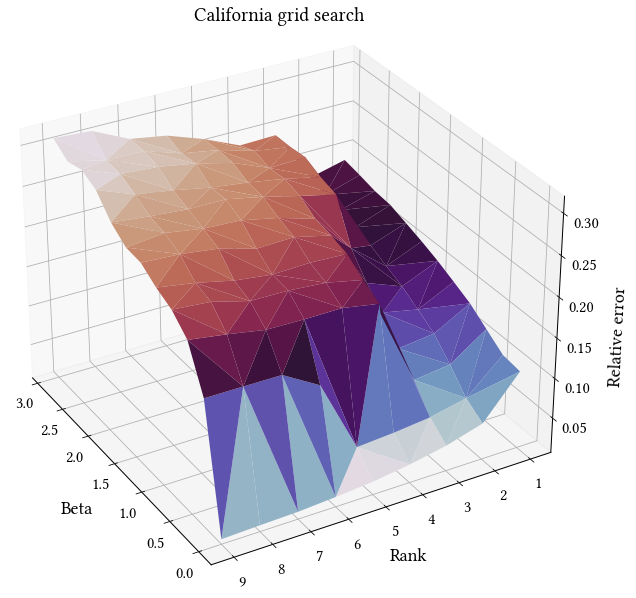

In [311]:
cali_grid = pd.read_csv("./testing_data/california_grid_search.csv")
cali_grid = cali_grid.loc[cali_grid["beta"] <= 3]
fig = plt.figure(figsize = (14,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(cali_grid['beta'], cali_grid['rank'], cali_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)

ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("California grid search")
ax.view_init(30,150)
ax.dist = 9

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/grid_california.pdf')

In [247]:
c = cali_grid["std error"].min()
cali_grid.loc[cali_grid["std error"] == c]

,rank,beta,relative error,std error
160,9,0.0,0.012558,0.000125


In [221]:
cali = pd.read_csv(os.path.join(par, 'collected_data/county_dataset.csv'), index_col = [0,1,2])
cali = cali.loc[cali.index.get_level_values("state").isin(["California"])]
cali.index = cali.index.get_level_values("fips")
cali = cali.T

In [222]:
cali_lapl = countyLaplacian.loc[cali.columns,cali.columns].to_numpy()
cali_pop = county_pop.loc[cali.columns, :]

In [327]:
import json
'''
with open(os.path.join(par, "collected_data/US_counties_geo.json"), 'r') as f:
    data = json.load(f)
    cali_counties = {'type': "FeatureCollection", "features":[]}
    for feat in range(len(data['features'])):
        county_id = data['features'][feat]['properties']['COUNTY_ID']
        
        if int(county_id) in cali.columns:
            cali_counties['features'].append(data['features'][feat])
        
    new_f = open(os.path.join(par, "collected_data/cali_counties_geo.json"), "w")
    json.dump(cali_counties, new_f)
    f.close()
    new_f.close()
'''


cali_map = os.path.join(par, 'collected_data/cali_counties_geo.json')

In [223]:
# clean + normalize
cali_dset = mat_opr(cali)
cali_iso = cali_dset.iso()
pop_dict = {}
for col in cali_iso.dataframe.columns:
    pop_dict[col] = cali_pop.loc[col,'Population Estimate']        
    
cali_norm = cali_iso.population_normalizer(pop_dict)

In [26]:
cali_errs = []
for r in range(1,15):
    nmfer = nmf(r, n_iter = 50000, tol = 1e-9)
    W,H = nmfer.fit_transform(cali_norm.dataframe)
    err = np.linalg.norm(cali_norm.dataframe - np.dot(W,H))/np.linalg.norm(cali_norm.dataframe)
    cali_errs.append(err)

Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance


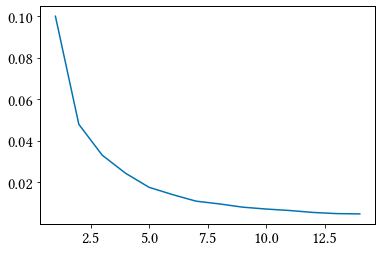

In [201]:
plt.plot(range(1,15), cali_errs)

In [347]:
rank = 5
beta = 1
cK = np.linalg.inv(np.identity(len(cali_lapl)) + beta * cali_lapl)
dNMF = diffusionNMF(n_components = rank, kernel = cK, n_iter = 100000, tol = 1e-9)
cX,cV = dNMF.fit_transform(cali_norm.dataframe)

In [348]:
cX,cV = rescale(cX,cV,cK)
cX = pd.DataFrame(cX, index = cali_norm.dataframe.index)
cV = pd.DataFrame(cV, columns = cali_norm.dataframe.columns)

In [349]:
nmfer = nmf(rank, n_iter = 500000, tol = 1e-9)
cW,cH = nmfer.fit_transform(cali_norm.dataframe)

In [352]:
cW,cH = rescale(cW,cH)
cW = pd.DataFrame(cW, index = cali_norm.dataframe.index)
cH = pd.DataFrame(cH, columns = cali_norm.dataframe.columns)

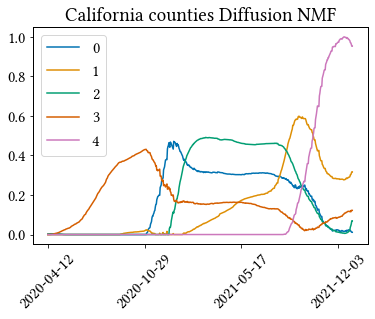

In [355]:
cX.plot()
plt.xticks(rotation = 45)
plt.title("California counties Diffusion NMF")
plt.show()

Text(0.5, 1.0, 'California counties NMF')

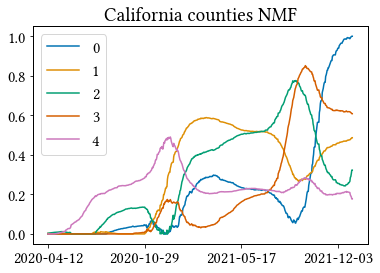

In [356]:
cW.plot()
plt.title("California counties NMF")

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


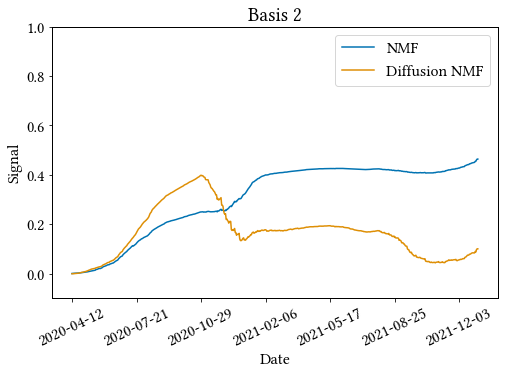

In [308]:
cW[2].plot(label = "NMF", figsize = (8,5))
cX[2].plot(label = "Diffusion NMF")
plt.ylim(-0.1,1)
plt.xticks(rotation = 25)
plt.xlabel("Date")
plt.ylabel("Signal")
plt.title("Basis 2")
plt.legend()
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/cali_basis2.pdf', bbox_inches = "tight")

In [328]:
m = folium.Map(location=[37, -120], width = 800, height = 800, zoom_start=6)
for r in [cV.index[2]]:
    basis = cV.loc[r,:]
    
    folium.Choropleth(
    geo_data=cali_map ,
    data=basis,
    key_on="feature.properties.COUNTY_ID",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

#folium.LayerControl().add_to(m)
m
#m.save("california.html")

In [329]:
cVK = cV @ cK
cVK.columns = cali_norm.dataframe.columns

m = folium.Map(location=[37, -120], width = 800, height = 800, zoom_start=6)
for r in [cVK.index[2]]:
    basis = cVK.loc[r,:] 
    
    folium.Choropleth(
    geo_data=cali_map,
    data=basis,
    key_on="feature.properties.COUNTY_ID",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

folium.LayerControl().add_to(m)
m
#m.save("california.html")

In [345]:
m = folium.Map(location=[37, -120], width = 800, height = 800, zoom_start=6)
for r in [cH.index[2]]:
    basis = cH.loc[r,:] 
    
    folium.Choropleth(
    geo_data=cali_map,
    data=basis,
    key_on="feature.properties.COUNTY_ID",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

folium.LayerControl().add_to(m)
m 
#m.save("california.html")

In [301]:
from selenium import webdriver
import time
driver = webdriver.Chrome()
driver.set_window_size(1000, 3000)  # choose a resolution
driver.get('file:///C:/Users/kq146/code/covid_college_tracker/Covid_data/analysis/california.html')
# You may need to add time.sleep(seconds) here
time.sleep(2)
driver.save_screenshot('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/california_H2.png')

True

### Midwest

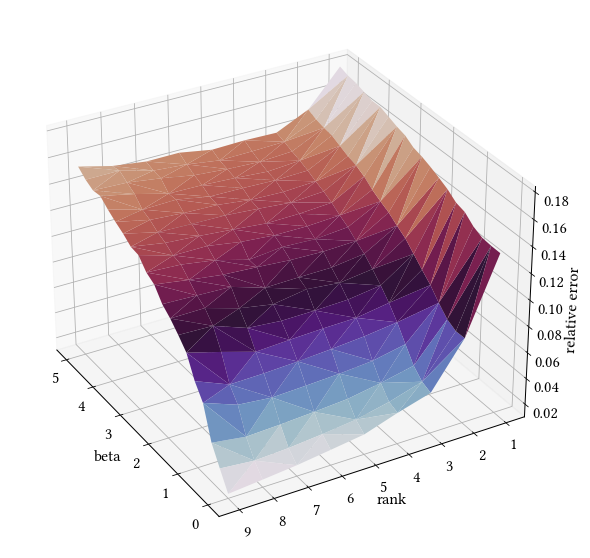

In [123]:
new_eng_grid = pd.read_csv("./testing_data/new_eng_grid.csv")
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(new_eng_grid['beta'], new_eng_grid['rank'], new_eng_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

In [240]:
midw = pd.read_csv(os.path.join(par, 'collected_data/county_dataset.csv'), index_col = [0,1,2])
midw = midw.loc[midw.index.get_level_values("state").isin(["North Dakota", "South Dakota"])]
midw.index = midw.index.get_level_values("fips")
midw = midw.T

In [242]:
midw_lapl = countyLaplacian.loc[midw.columns,midw.columns].to_numpy()
midw_pop = county_pop.loc[midw.columns, :]

In [243]:
# clean + normalize
midw_dset = mat_opr(midw)
midw_iso = midw_dset.iso()
pop_dict = {}
for col in midw_iso.dataframe.columns:
    pop_dict[col] = midw_pop.loc[col,'Population Estimate']        
    
midw_norm = midw_iso.population_normalizer(pop_dict)

In [244]:
midw_errs = []
for r in range(1,15):
    nmfer = nmf(r, n_iter = 50000, tol = 1e-9)
    W,H = nmfer.fit_transform(midw_norm.dataframe)
    err = np.linalg.norm(midw_norm.dataframe - np.dot(W,H))/np.linalg.norm(midw_norm.dataframe)
    midw_errs.append(err)

Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance


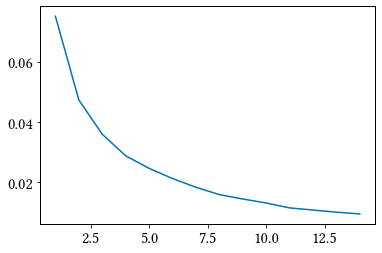

In [245]:
plt.plot(range(1,15), midw_errs)

In [268]:
rank = 5
beta = 3
mK = np.linalg.inv(np.identity(len(midw_lapl)) + beta * midw_lapl)
dNMF = diffusionNMF(n_components = rank, kernel = mK, n_iter = 100000  , tol = 1e-9)
mX,mV = dNMF.fit_transform(midw_norm.dataframe)
mX = pd.DataFrame(mX, index = midw_norm.dataframe.index)
mV = pd.DataFrame(mV, columns = midw_norm.dataframe.columns)

Max iterations reached, increase to converge on given tolerance


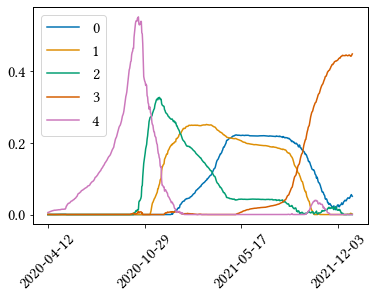

In [269]:
mX.plot()
plt.xticks(rotation = 45)
plt.show()

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)
for r in [mV.index[1]]:
    basis = mV.loc[r,:]
    
    folium.Choropleth(
    geo_data=county_map ,
    data=basis,
    key_on="feature.properties.COUNTY_ID",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

folium.LayerControl().add_to(m)
m

In [ ]:
mVK = mV @ mK
mVK.columns = midw_norm.dataframe.columns

m = folium.Map(location=[48, -102], zoom_start=3)
for r in [mVK.index[1]]:
    basis = mVK.loc[r,:] 
    
    folium.Choropleth(
    geo_data=county_map,
    data=basis,
    key_on="feature.properties.COUNTY_ID",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

folium.LayerControl().add_to(m)
m

In [261]:
nmfer = nmf(rank, n_iter = 100000, tol = 1e-9)
W,H = nmfer.fit_transform(midw_norm.dataframe)
W = pd.DataFrame(W, index = midw_norm.dataframe.index)
H = pd.DataFrame(H, columns = midw_norm.dataframe.columns)

Max iterations reached, increase to converge on given tolerance


<AxesSubplot:>

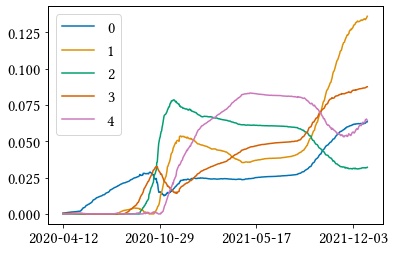

In [262]:
W.plot()

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)
for r in [H.index[3]]:
    basis = H.loc[r,:] 
    
    folium.Choropleth(
    geo_data=county_map,
    data=basis,
    key_on="feature.properties.COUNTY_ID",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

folium.LayerControl().add_to(m)
m

### All counties

In [69]:
# Load original data
county_data = pd.read_csv(os.path.join(par, 'collected_data/county_dataset.csv'), index_col = [0,1,2])
county_data.index = county_data.index.get_level_values("fips")
county_data = county_data.T
county_data.columns = county_data.columns.astype("string")

In [3]:
# geo json map
county_map = os.path.join(par, 'collected_data/US_counties_geo.json')

In [4]:
# county laplacian
countyLaplacian = pd.read_csv(os.path.join(par, "collected_data/countyLaplacian.csv"), index_col = 0).to_numpy()

In [5]:
# county census data for normalization
county_pop = pd.read_csv(os.path.join(par, "collected_data/county_census.csv"), index_col = "fips")

In [6]:
# clean + normalize
county_dset = mat_opr(county_data)
county_iso = county_dset.iso()
pop_dict = {}
for col in county_iso.dataframe.columns:
    pop_dict[col] = county_pop.loc[col,'Population Estimate']        
    
county_norm = county_iso.population_normalizer(pop_dict)

In [38]:
# Not sure if this is relevant anymore...

import json

with open(os.path.join(par, "collected_data/US-counties.geojson"), 'r') as f:
    data = json.load(f)
    for feat in range(len(data['features'])):
        county_id = int(data['features'][feat]['properties']['STATE'] + data['features'][feat]['properties']['COUNTY'])
        data['features'][feat]['properties']['COUNTY_ID'] = county_id
        
    new_f = open(os.path.join(par, "collected_data/US_counties_geo.json"), "w")
    json.dump(data, new_f)
    f.close()
    new_f.close()

#### Grid results

In [10]:
county1 = pd.read_csv("./testing_data/covid_county_grid_search1.csv")
county2 = pd.read_csv("./testing_data/covid_county_grid_search2.csv")
county3 = pd.read_csv("./testing_data/covid_county_grid_search3.csv")

In [20]:
counties = pd.concat([county1, county2, county3])

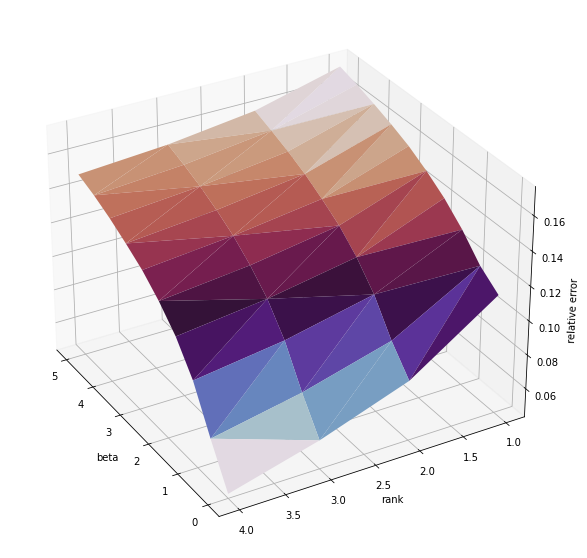

In [11]:
counties = county1
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(counties['beta'], counties['rank'], counties['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

In [20]:
rank = 10
beta = 1
K = np.linalg.inv(np.identity(len(countyLaplacian)) + beta * countyLaplacian)
dNMF = diffusionNMF(n_components = rank, kernel = K, n_iter = 1000  , tol = 1e-9)
X,V = dNMF.fit_transform(county_norm.dataframe)

Max iterations reached, increase to converge on given tolerance


In [21]:
X = pd.DataFrame(X, index = county_norm.dataframe.index)
V = pd.DataFrame(V, columns = county_norm.dataframe.columns)

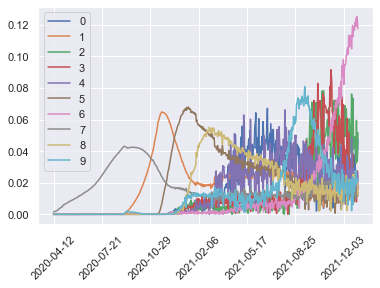

In [22]:
X.plot()
plt.xticks(rotation = 45)
plt.show()

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)
for r in V.index:
    basis = V.loc[r,:]
    
    folium.Choropleth(
    geo_data=county_map ,
    data=basis,
    key_on="feature.properties.COUNTY_ID",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

folium.LayerControl().add_to(m)
m

## World Level data

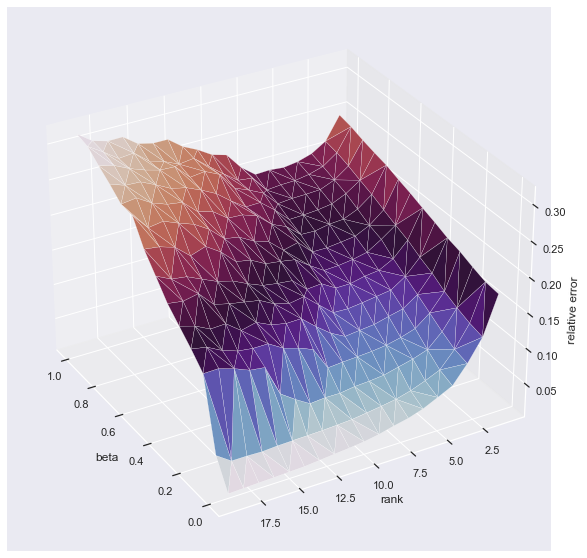

In [20]:
world_grid = pd.read_csv("./testing_data/covid_world_grid_search.csv")
world_grid = world_grid[world_grid["beta"] <= 1]
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(world_grid['beta'], world_grid['rank'], world_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

In [4]:
world_data = pd.read_csv(os.path.join(par, 'collected_data/world_dataset.csv'), index_col = 0)
world_laplacian = pd.read_csv(os.path.join(par, 'collected_data/worldLaplacian.csv'), index_col = 0).to_numpy()
# geo json map
world_map = os.path.join(par, 'collected_data/countries_geo.geojson')
world_population = pd.read_csv(os.path.join(par, 'collected_data/world_population.csv'), index_col = "Country")

In [5]:
# clean + normalize
world_dset = mat_opr(world_data)
world_iso = world_dset.iso()
pop_dict = {}
for col in world_iso.dataframe.columns:
    pop_dict[col] = world_population.loc[col,'Population']
    
world_norm = world_iso.population_normalizer(pop_dict)
world_norm = world_norm.dataframe

In [6]:
rank = 10
beta = 0.1
K = np.linalg.inv(np.identity(len(world_laplacian)) + beta * world_laplacian)
dNMF = diffusionNMF(n_components = rank, kernel = K, n_iter = 100000, tol = 1e-9)
X,V = dNMF.fit_transform(world_norm)

Max iterations reached, increase to converge on given tolerance


In [8]:
X = pd.DataFrame(X, index = world_norm.index)
V = pd.DataFrame(V, columns = world_norm.columns)

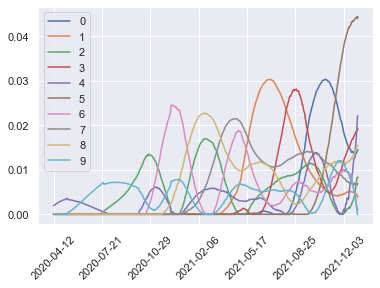

In [9]:
X.plot()
plt.xticks(rotation = 45)
plt.show()

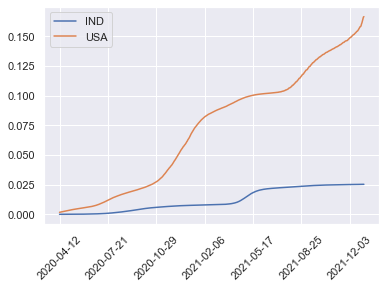

In [30]:
world_norm[["IND", "USA"]].plot()
plt.xticks(rotation = 45)
plt.show()

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)
for r in V.index:
    basis = V.loc[r,:]
    
    folium.Choropleth(
    geo_data=world_map ,
    data=basis,
    key_on="feature.properties.ISO_A3",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

folium.LayerControl().add_to(m)
m

#### NMF

In [11]:
nmfer = nmf(rank, n_iter = 100000, tol = 1e-8)
W,H = nmfer.fit_transform(world_norm)

Max iterations reached, increase to converge on given tolerance


In [12]:
W = pd.DataFrame(W, index = world_norm.index)
H = pd.DataFrame(H, columns = world_norm.columns)

<AxesSubplot:>

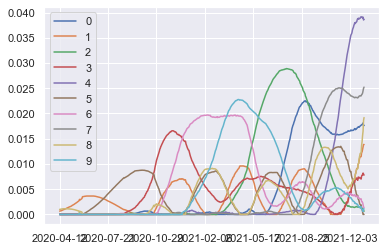

In [13]:
W.plot()

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)
for r in H.index:
    basis = H.loc[r,:]
    
    folium.Choropleth(
    geo_data=world_map ,
    data=basis,
    key_on="feature.properties.ISO_A3",
    legend = False,
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name = "Basis " + str(r),
    overlay = True,
    ).add_to(m)

folium.LayerControl().add_to(m)
m